In [1]:
%matplotlib notebook

In [27]:
# SETUP
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets as widgets

# ZOIDBERG STUFF
# import Zoidberg.zoidpol as zp
import Zoidberg.zoidpol_phg_test as zp
import Zoidberg.rzline as rz

# W7XGRID STUFF
import tracer.W7X.make_W7X_grid_phg_test as w7xt

# should the w7xgridcode print (pp) info and plot (pl) some of the grid?
pp, pl = False, False 

# grid parameters, you can add more!
constants = {"NirS": 5, "NirC": 5, "NirN": 10,  # in -> outside cell number 
             "Nit": 37,
             "Niphalf": 50, "is_bean": True,  # half pol cell number
             "eq_space": True, "eq_space_vessel": False,
             "zoidpol": False}

In [28]:
try:
    assert(0) # False when you want to generate new g
    g = np.load("g.npy")
except:
    # 1) Generate the inner grid with the W7Xgrid routines
    ''' this returns the first grid version 
    g[r,tht,phi] = [R,z,phi] as well as some parameters needed for the other
    functions and a figure axis tuple for looking at the plotted grid.
    to change the parameters of this grid, one needs to change the inputs
    of the constants dict given as the first param of make_inner_grid.
    '''
    out = w7xt.make_inner_grid(consts=constants, pprint=pp, plot=pl)
    g, glob, consts, plots = out
    
    # 2) Set the outermost layer of the grid to the shape of the plasma vessel
    ''' this changes g[-1,:,:,:] to be the shape of the plasma vessel,
    while taking the outputs of the functions above, changing them
    approprietly (g[-1], possible changes in glob, new plots in ax)
    '''
    out = w7xt.make_outer_boundary(g, glob, consts, plots, pprint=pp, plot=pl)
    
    
    # OLD 3) would naively fill the middle layers outside of the islands
    if not constants["zoidpol"]:
        g, plots = w7xt.make_outer_grid(g, glob, consts, plots,
                                        pprint=pp, plot=pl)
        if(pl): plt.close(plots[0])
    
    np.save("g.npy", g)

File: W7X-VacuumVessel-Medium.kis
Kisslinger mesh with 21 Phi values with 73 R,Z values per phi.
5-fold periodicity
Reference point: 0.000000 [cm] 0.000000 [cm] (R,Z)


In [29]:
### FIRST TRY: KEEP EDGE POINTS (g[-1] & g[-1-NirN]) CONST, ZOID MIDDLE
if constants["zoidpol"]:
    for phi in range(g.shape[2]):
        rvres, polres = constants["NirN"], 2*constants["Niphalf"]  # rvesselres
        # define edge lines. zoidberg doesnt want equal beginning and end points
        # therefor the last point of the line gets cut of :-1 (*)
        inEdge, outEdge = g[-1-rvres,:-1,phi,:], g[-1,:-1,phi,:]
        inner = rz.RZline(inEdge[:,0],inEdge[:,1])
        outer = rz.RZline(outEdge[:,0],outEdge[:,1])
        
        # make zoidberg interpolation
        # inner wall, outer wall, radial resolution, poloidal resolution
        grid = zp.grid_elliptic(inner, outer, rvres+1, polres, align=False, show=pl)
        
        # place grid into g (edges that are the same will also be inserted)
        # -1-constants["NirN"]: -> every radius from the plasma boundary to the vessel
        # :-1 -> every poloida angle except the last because grid doesnt contain it
        #        the last is the same as the first so it is copied extra
        # PHISTUFF
        # 0 or 1 == R or z that need to be replaced. 2 == phi can stay as it is
        g[-1-rvres:,:-1,phi,0] = grid.R; g[-1-rvres:,-1,phi,0] = grid.R[:,0]
        g[-1-rvres:,:-1,phi,1] = grid.Z; g[-1-rvres:,-1,phi,1] = grid.Z[:,0]

In [30]:
def quick_g_plot(g, phi=-1, title=None, widget=False):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_aspect("equal")
    if(title is not None): ax.set_title(title)
    fig.tight_layout()
    
    def g_plot(phi):
        ax.clear()
        print(g.shape, phi)
        R, z, _ = np.transpose(g[:,:,phi,:], (2,0,1))
        ax.plot(R,z, c="blue", lw=0.3)
        ax.plot(R.T,z.T, c="red", lw=0.3)
    
    if widget:
        phi = widgets.IntSlider(min=0, max=constants["Nit"]-1, value=0, step=1)
        widgets.interact(g_plot, phi = phi)
    else:
        g_plot(phi)

<IPython.core.display.Javascript object>


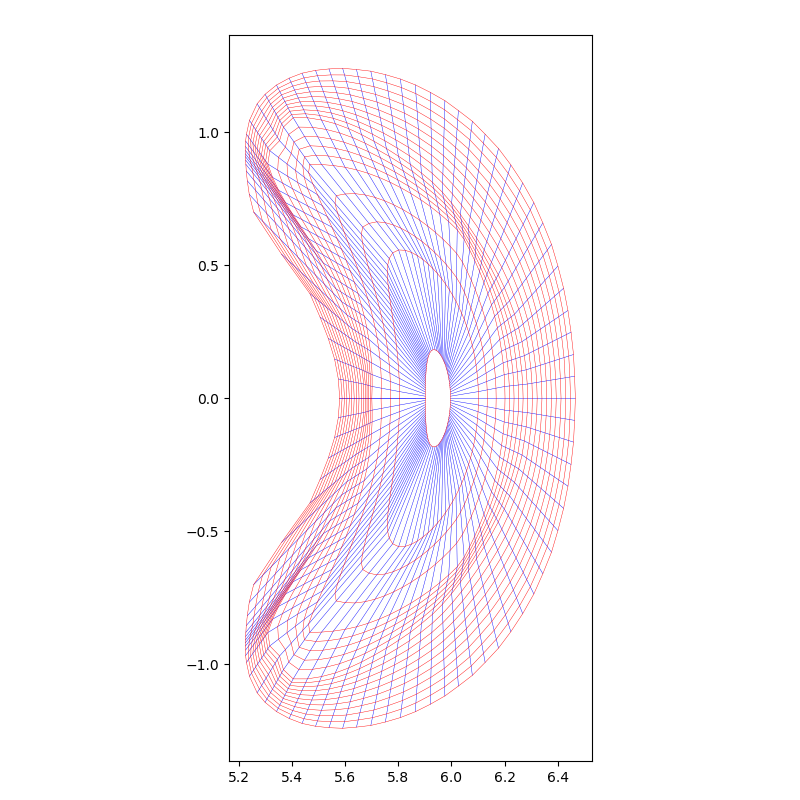

interactive(children=(IntSlider(value=0, description='phi', max=36), Output()), _dom_classes=('widget-interact…

In [31]:
quick_g_plot(g, phi=0, title="NEW", widget=True)